# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('../work_space/MMM/vk_fest/notebooks/')

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import statsmodels.api as sm
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt,ExponentialSmoothing
from scipy.interpolate import interp1d
from plotly.subplots import make_subplots
from prophet import Prophet
from IPython.display import display
import sys
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
from IPython.display import Markdown, SVG, display
pd.options.display.float_format = '{:.3f}'.format
import psycopg2
from dotenv import load_dotenv
from mmm_tools.model_building import create_media_params_dict, calculate_media_impact,media_impact_log_lin
from mmm_tools.media_transformation import upload_media_params_file, create_optimal_params_dict, transform_media_data, plot_transformed_data,adstock
from mmm_tools.model_plotting import plot_decomposition
from mmm_tools.model_quality_estimation import SMAPE

In [3]:
df_initial = pd.read_excel('../data/df.xlsx',sheet_name='daily_organic').fillna(0)
df_initial.set_index('date',inplace=True)

date_start_2024 = '2024-01-01'
df_initial = df_initial.loc[date_start_2024:]

In [4]:
media_factors_vk_fest = [
'tv_nat_ots_ta_14_44',
    
'tv_msc_ots_ta_14_44', 'tv_spb_ots_ta_14_44', 'tv_novosib_ots_ta_14_44', 'tv_vladiv_ots_ta_14_44',
'tv_sochi_ots_ta_14_44', 'tv_krasnoyarsk_ots_ta_14_44','tv_ufa_ots_ta_14_44', 
    
'ooh_ots_total_msc', 'ooh_ots_total_spb', 'ooh_ots_total_sochi', 'ooh_ots_total_krasnoyarsk',
'ooh_ots_total_ufa', 'ooh_ots_total_novosib', 'ooh_ots_total_vladiv',

'media_facades_ots_total_msc', 'media_facades_ots_total_spb', 'media_facades_ots_total_sochi',
'media_facades_ots_total_krasnoyarsk', 'media_facades_ots_total_ufa', 'media_facades_ots_total_novosib',
'media_facades_ots_total_vladiv',

'touchpoints_ots_total_msc', 'touchpoints_ots_total_spb','touchpoints_ots_total_sochi','touchpoints_ots_total_krasnoyarsk',
'touchpoints_ots_total_ufa', 'touchpoints_ots_total_novosib', 'touchpoints_ots_total_vladiv',
    
'radio_ots_ta_main_msc', 'radio_ots_ta_main_spb', 'radio_ots_ta_main_sochi', 'radio_ots_ta_main_krasnoyarsk',
'radio_ots_ta_main_ufa', 'radio_ots_ta_main_novosib', 'radio_ots_ta_main_vladiv',
    
'digital_media_total_ots_total', 'perform_total_ots_total',
'digital_media_total_ots_ru', 'perform_total_ots_ru',
'digital_media_total_ots_msc', 'perform_total_ots_msc',
'digital_media_total_ots_spb', 'perform_total_ots_spb',
'digital_media_total_ots_sochi', 'perform_total_ots_sochi',
'digital_media_total_ots_krasnoyarsk', 'perform_total_ots_krasnoyarsk',
'digital_media_total_ots_ufa', 'perform_total_ots_ufa'
]

# Moscow

In [5]:
date_start_sales_2024 = '2024-03-01'
date_end_fest_2024 = '2024-07-14'
date_start_fest_2024 = '2024-07-13'
kpi_name = 'msc_tickets'
kpi_name_log = 'msc_tickets_log'
df_initial[kpi_name_log] = np.log1p(df_initial[kpi_name])

In [6]:
df_initial[kpi_name].iplot()

In [7]:
df_initial[kpi_name_log].iplot()

### Definition of media factors

In [8]:
media_oudoor_factors = ['ooh_ots_total_msc','media_facades_ots_total_msc', 'touchpoints_ots_total_msc']
other_factors = ['temp_msc','msc_real_inc']

df_initial['media_outdoor_total_ots'] = df_initial[media_oudoor_factors].sum(axis=1)

media_factors = ['tv_nat_ots_ta_14_44', 'tv_msc_ots_ta_14_44',
                 'media_outdoor_total_ots',
                 'radio_ots_ta_main_msc',
                 'digital_media_total_ots_msc','digital_media_total_ots_ru', 'digital_media_total_ots_total',
                 'perform_total_ots_ru', 'perform_total_ots_total', 'perform_total_ots_msc']


model_factors = media_factors + other_factors

### Seasonality and trend from Prophet

18:16:52 - cmdstanpy - INFO - Chain [1] start processing
18:16:52 - cmdstanpy - INFO - Chain [1] done processing


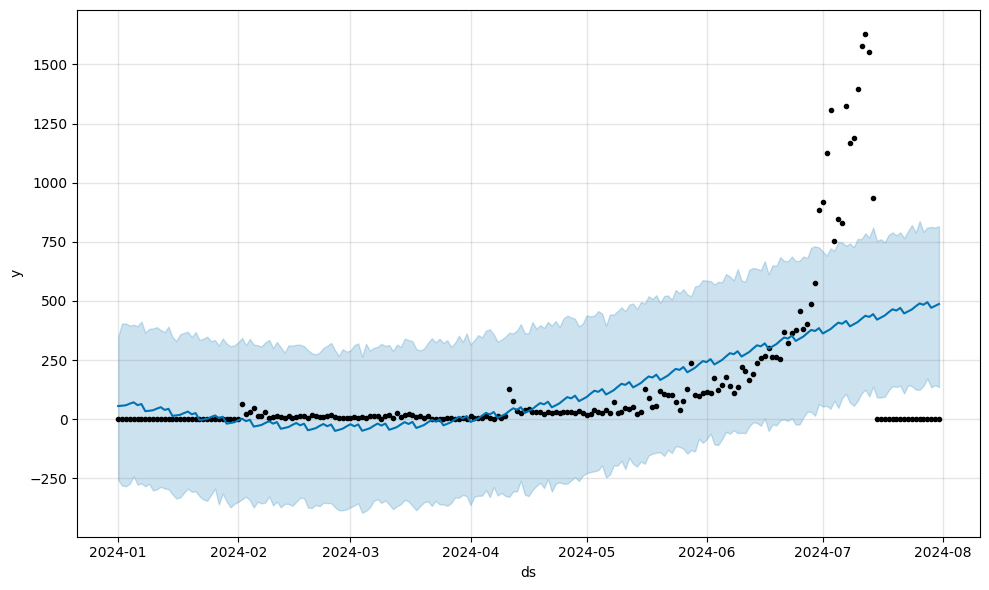

In [9]:
data = df_initial.reset_index().rename(columns={'date':'ds',kpi_name:'y'}).copy()
model = Prophet(growth='linear',
                seasonality_mode='additive', 
                weekly_seasonality=True, 
                yearly_seasonality=1, # 2 гармоники 
                seasonality_prior_scale=30)
model.fit(data)

future = model.make_future_dataframe(periods=0)

# future['cap'] = trend(horizont)

forecast = model.predict(future)

# Визуализация результатов
fig = model.plot(forecast)

forecast.index = forecast.ds

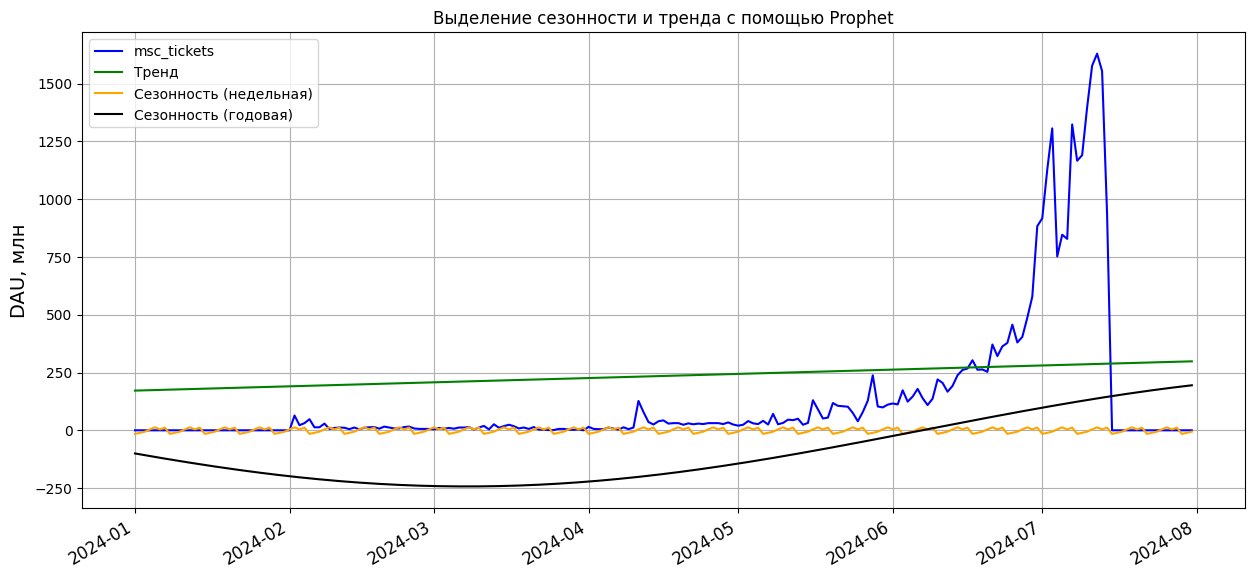

In [10]:
# Визуализация результатов
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(data['ds'], data['y'], label=kpi_name, color='blue')
ax.plot(data['ds'], forecast['trend'], label='Тренд', color='green')
ax.plot(data['ds'], forecast['weekly'], label='Сезонность (недельная)', color='orange')
ax.plot(data['ds'], forecast['yearly'], label='Сезонность (годовая)', color='black')
# ax.plot(data['ds'], forecast['holiday'], label='праздники', color='red')
plt.legend()
plt.grid(True)
plt.title('Выделение сезонности и тренда с помощью Prophet')
plt.xticks(fontsize=12)
plt.ylabel('DAU, млн',fontsize=14)
# ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.gcf().autofmt_xdate()
plt.show()

In [11]:
df_initial['seasonality_yearly'] = forecast['yearly']
df_initial['seasonality_weekly'] = forecast['weekly']

### Trend from Multiplicative Holt-Winters model

SMAPE = 28.532


/Users/i.nuriev/Library/Caches/pypoetry/virtualenvs/mmm-tools-9U9JP_nD-py3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



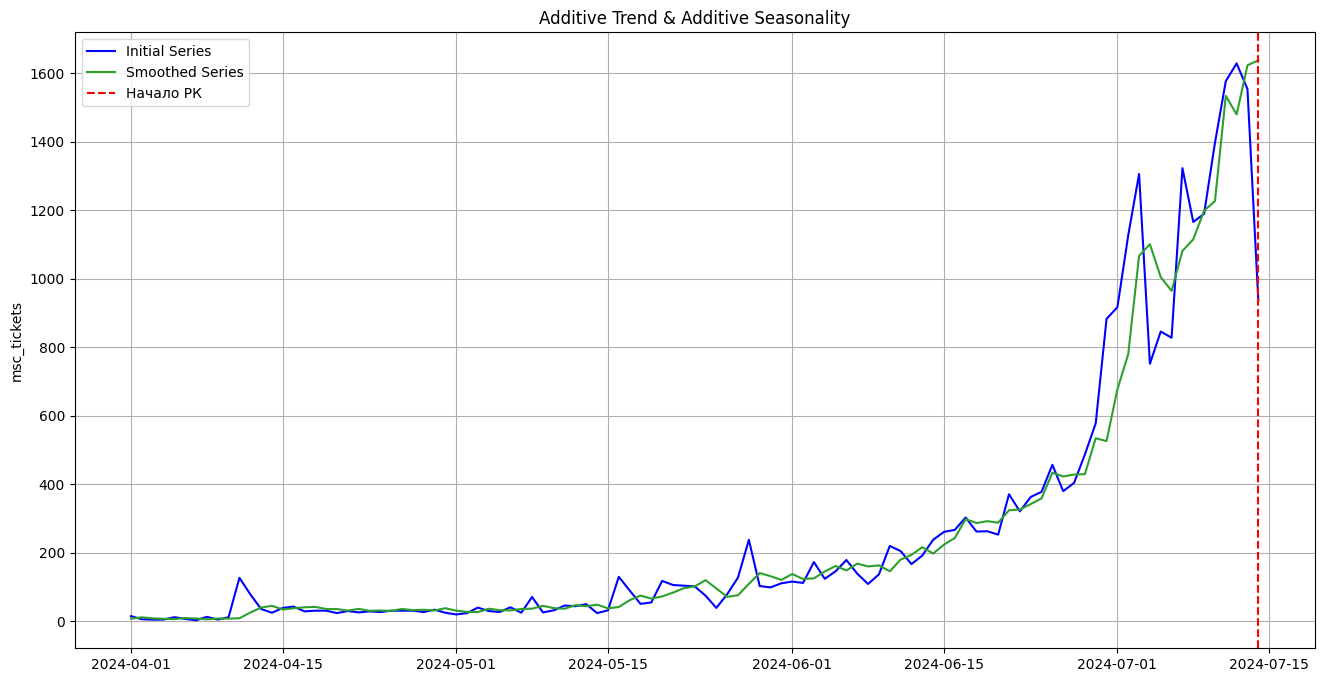

In [12]:
### Сглаживание
date_when_not_null = '2024-04-01'
y_2024 = df_initial[kpi_name].loc[date_when_not_null:date_end_fest_2024]
mult_add = ExponentialSmoothing(
    y_2024,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()
# метрики качества
smape_mult_add = round(SMAPE(y_2024, mult_add.fittedvalues),3)
print(f'SMAPE = {smape_mult_add}')
### График
plt.figure(figsize=(16,8))
plt.ylabel(kpi_name)
plt.title("Additive Trend & Additive Seasonality")
line_1,=plt.plot(y_2024,color='blue',label='Initial Series')
line_2,=plt.plot(mult_add.fittedvalues, color='tab:green',label='Smoothed Series')
plt.grid(True)
plt.gca()
plt.axvline(pd.to_datetime(date_end_fest_2024), color='red', linestyle='--',label='Начало РК')
plt.legend()

plt.show()

### Ticket prices and sales each day

In [13]:
intickets_msc = pd.read_excel('../data/intickets_msc.xlsx',sheet_name='raw')

In [14]:
intickets_msc['Сеанс'].replace({'13.07.2024 12:00':'2024-07-13',
                           '14.07.2024 12:00':'2024-07-14',
                           '2024-07-14 12:00:00':'2024-07-14'},inplace=True)

In [15]:
intickets_msc[intickets_msc['Мероприятие'].eq('VK FEST 2024 МОСКВА')].Сектор.value_counts()

Сектор
Входной                     30545
Входной на 2 дня            12843
Детский                      4415
Входной Добрый               3953
Входной Добрый на 2 дня      1956
Детский на 2 дня             1400
Вездеход                      633
Вездеход Добрый               232
Вездеход на 2 дня             219
Вездеход Добрый на 2 дня       58
Name: count, dtype: int64

In [16]:
intickets =     intickets_msc[intickets_msc['Скидка'].eq('Без промокода') & \
                intickets_msc['Возврат'].eq('Продажа') & \
                intickets_msc['Мероприятие'].eq('VK FEST 2024 МОСКВА') & \
                intickets_msc['Сектор'].isin(['Входной','Входной на 2 дня','Детский','Входной Добрый']) & \
                intickets_msc['Сеанс'].eq('2024-07-13') ].reset_index(drop=True)
intickets['Сеанс'] = pd.to_datetime(intickets['Сеанс'])

In [17]:
intickets.rename(columns={'Дата оплаты':'date',
                          'Цена билета':'price_ticket',
                          'Возврат':'sales_tickets'},inplace=True)
intickets.date = pd.to_datetime(intickets['date'], format='%d.%m.%Y')

# оставляем только те цены, при которых было наибольшее количество продаж в этот день
price_ticket = intickets.groupby(['date','Сектор']).apply(lambda x: x.loc[x['sales_tickets'].idxmax(),'price_ticket'])
price_ticket.name = 'price_ticket'
# Считаем количество продаж на каждый день и добавляем колонку с ценами
data = intickets.groupby(['date','Сектор']).agg({'sales_tickets':'count'}).join(price_ticket)
data.reset_index('Сектор',inplace=True)

In [18]:
data_admission_1 = data[data.Сектор.eq('Входной')].rename(columns = {'price_ticket':'price_admission_ticket_first_day_2024',
                                                  'sales_tickets':'sales_admission_tickets_first_day_2024'})

data_admission_2 = data[data.Сектор.eq('Входной на 2 дня')].rename(columns = {'price_ticket':'price_admission_ticket_two_days_2024',
                                                  'sales_tickets':'sales_admission_tickets_two_days_2024'})

data_admission_child = data[data.Сектор.eq('Детский')].rename(columns = {'price_ticket':'price_child_ticket_first_days_2024',
                                                                                  'sales_tickets':'sales_child_tickets_first_days_2024'})

data_admission_1_kind = data[data.Сектор.eq('Входной Добрый')].rename(columns = {'price_ticket':'price_kind_ticket_first_days_2024',
                                                                                  'sales_tickets':'sales_kind_tickets_first_days_2024'})

In [19]:
data_admission = data_admission_1.merge(data_admission_2,how='outer',left_index=True,right_index=True)
data_admission_child = data_admission.merge(data_admission_child,how='outer',left_index=True,right_index=True)
data_prices = data_admission_child.merge(data_admission_1_kind.price_kind_ticket_first_days_2024,how='outer',left_index=True,right_index=True).fillna(0)

price_names = ['price_admission_ticket_first_day_2024','price_admission_ticket_two_days_2024',
               'price_child_ticket_first_days_2024','price_kind_ticket_first_days_2024']

In [20]:
delta_prices = data_prices[price_names].diff().fillna(0).rename(columns={
    'price_admission_ticket_first_day_2024':'delta_price_admission_ticket_first_day_2024',
    'price_admission_ticket_two_days_2024':'delta_price_admission_ticket_two_days_2024',
    'price_child_ticket_first_days_2024':'delta_price_child_ticket_first_days_2024',
    'price_kind_ticket_first_days_2024':'delta_price_kind_ticket_first_days_2024'})

delta_price_names = ['delta_price_admission_ticket_first_day_2024','delta_price_admission_ticket_two_days_2024',
               'delta_price_child_ticket_first_days_2024','delta_price_kind_ticket_first_days_2024']

In [21]:
df_initial = df_initial.merge(delta_prices,how='left',left_index=True,right_index=True).fillna(0)

### Scaling data

In [22]:
model_factors.extend(delta_price_names + ['seasonality_yearly','seasonality_weekly'])

In [23]:
scaler = MinMaxScaler()
scaler.fit(df_initial[model_factors].copy())
df_scaled = scaler.transform(df_initial[model_factors].copy())
df_scaled = pd.DataFrame(
    data=df_scaled,
    index=df_initial.index,
    columns=model_factors
)
df_scaled_ = df_scaled.join(df_initial[[kpi_name,kpi_name_log]])

### Preprocessing of outdoor advertising

In [24]:
# гео-данные
df_cw = pd.read_excel('../data/MS CW geo apps total custom daily_12-44.xlsx', skiprows=range(7))
df_cw.rename(columns = {'Дата':'date'},inplace=True)
df_cw['date'] = pd.to_datetime(df_cw['date']) 
df_cw_agg = df_cw[(df_cw['Медиа'].isin(['Большая Москва'])) & 
                  (df_cw['ЦА'] == '12-44') &
                  (df_cw['Гео'] == 'Geo apps total') ].reset_index(drop=True)

df_cw_agg['total_internet'] = df_cw.loc[(df_cw['Медиа'].eq('Большая Москва')) & 
                                  (df_cw['Гео'] == 'Total Internet') &
                                  (df_cw['ЦА'] == '12-44'),['Охват']].reset_index(drop=True)
df_cw_agg['share_geo'] = df_cw_agg['Охват'] / df_cw_agg['total_internet']
df_cw_agg.index = df_cw_agg.date

##### Outdoor advertising transformation

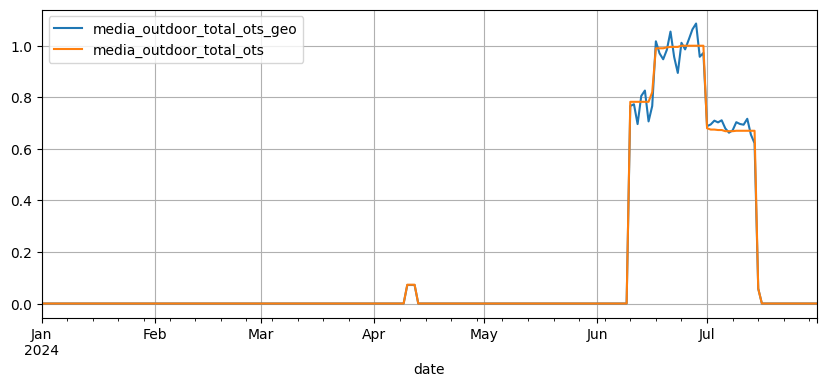

In [25]:
date_media_outdoor_start = '2023-05-01'
date_media_outdoor_end = '2024-07-14'

df_scaled = df_scaled_.merge(df_cw_agg[['total_internet','share_geo']],how='left', right_index=True,left_index=True).fillna(0)
share_geo = df_scaled['share_geo']

ooh = df_scaled['media_outdoor_total_ots']
val = (ooh*share_geo)
val.fillna(0,inplace=True)

df_scaled['media_outdoor_total_ots_geo'] = np.where(val == 0, ooh, val/sum(val) * ooh.loc[date_media_outdoor_start:date_media_outdoor_end].sum())
# график
plt.figure(figsize=(10,4))
df_scaled['media_outdoor_total_ots_geo'].plot()
df_scaled['media_outdoor_total_ots'].plot()
plt.grid(True)
plt.legend()
plt.show()

### Media transformation

In [26]:
file_path = '../configs/media_params_optimal_msc_2024.xlsx'

media_params_input = upload_media_params_file(file_path)
media_params_optimal = create_optimal_params_dict(
    media_params_input,
    media_params_input['media'],
)

In [27]:
df_transformed = transform_media_data(
    df_scaled,
    media_params_optimal,
    list(media_params_optimal.keys()),
    is_adstock=True,
    is_saturate=True,
    saturate_func='saturate_power',
)

#### Plot transformed data

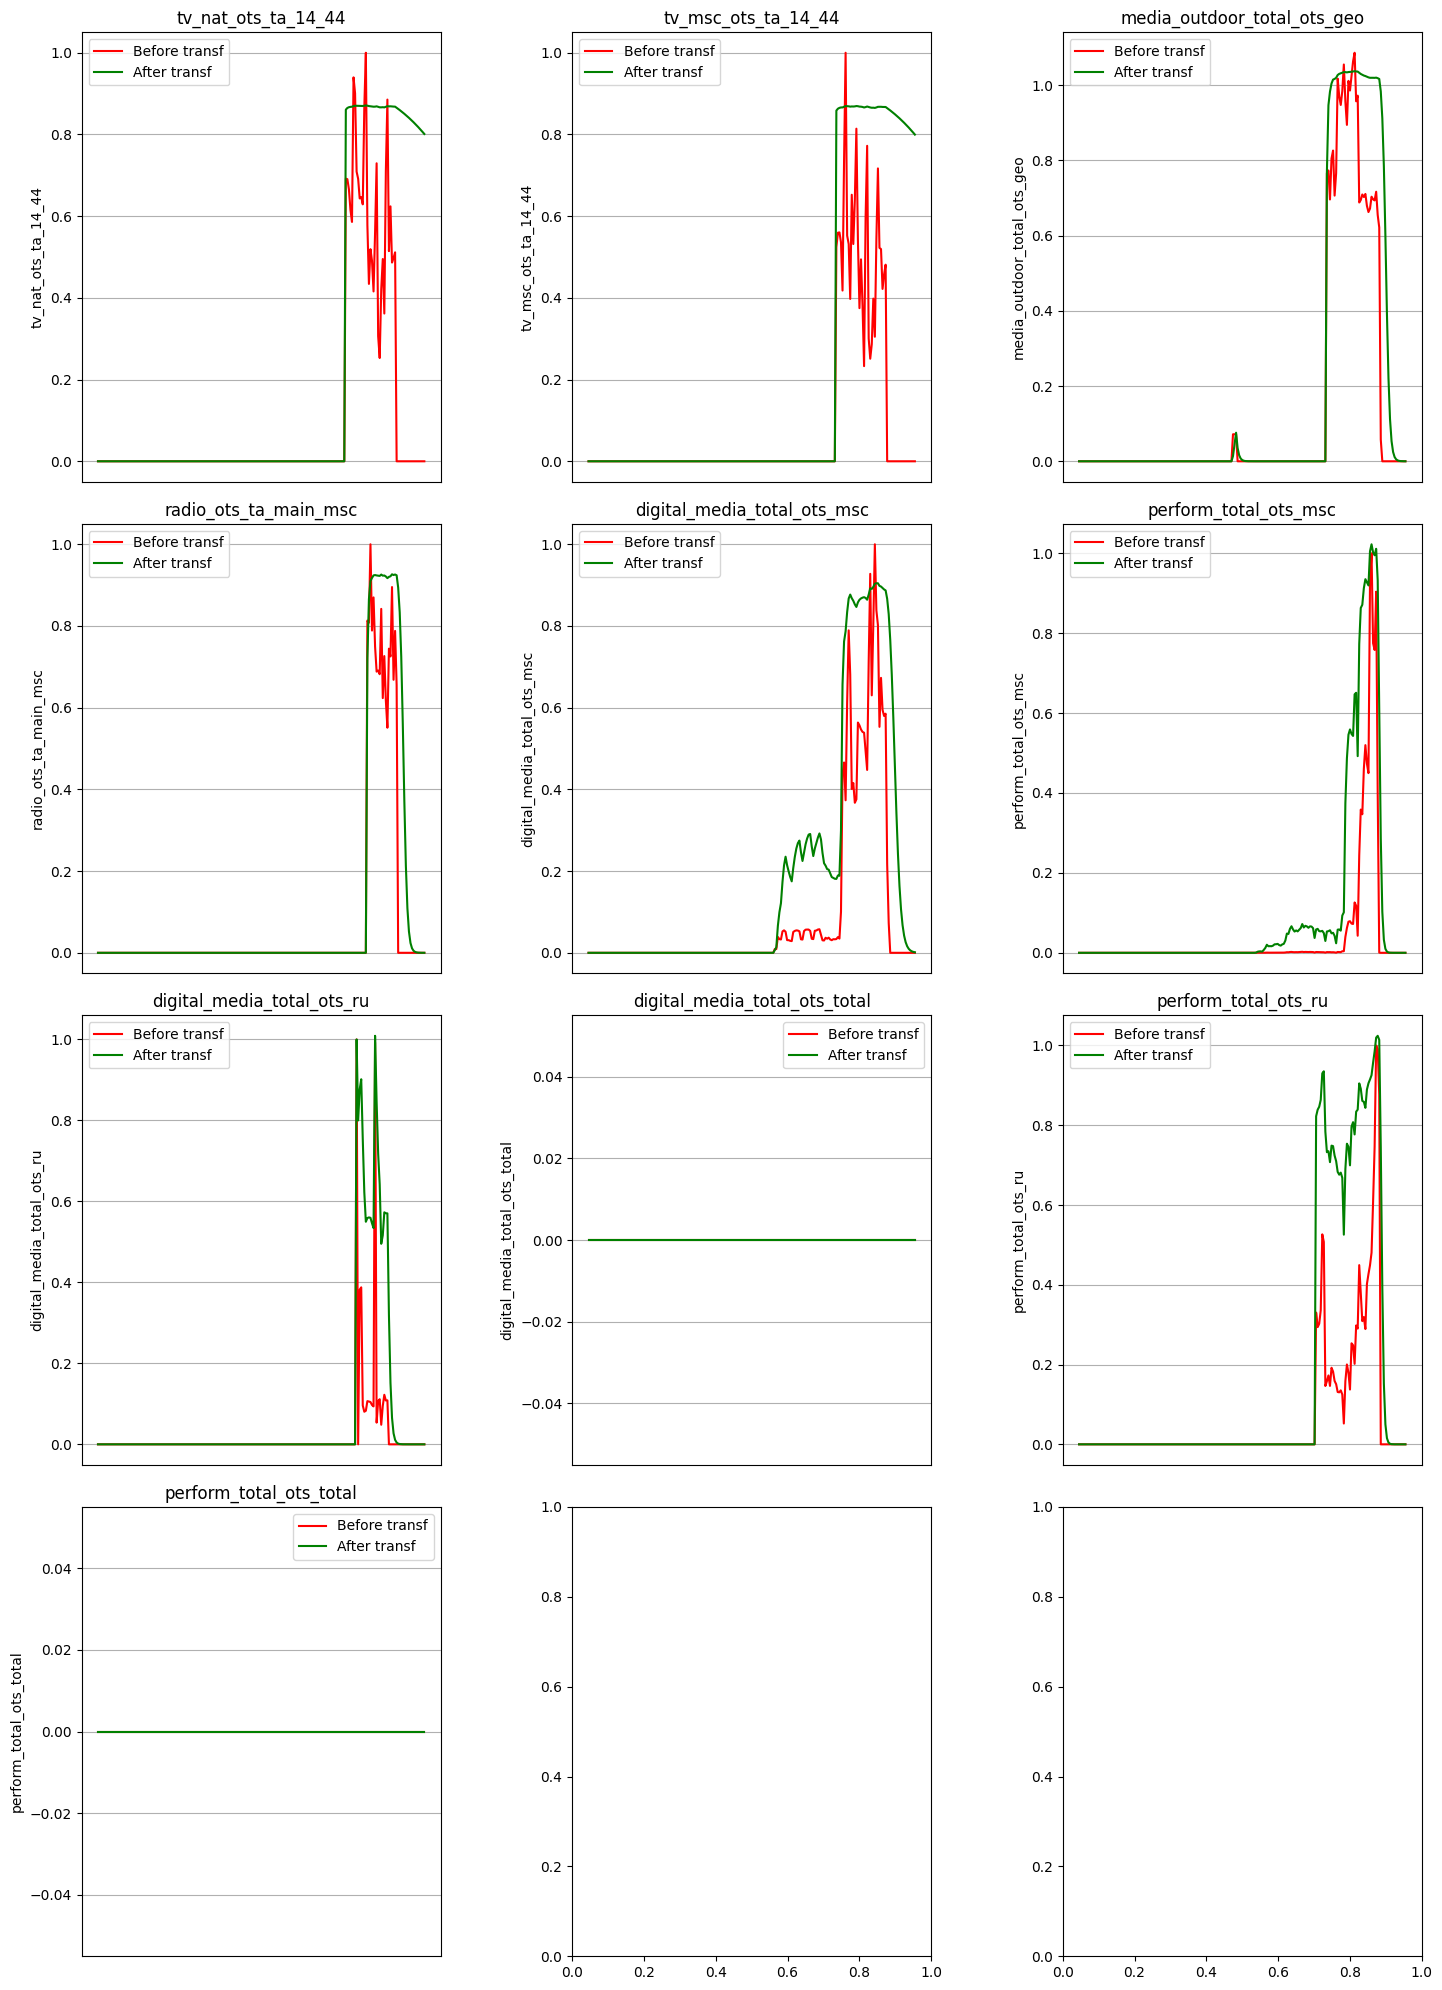

In [28]:
plot_transformed_data(df_scaled, df_transformed, list(media_params_optimal.keys()))

In [29]:
df_scaled_fin = df_scaled.drop(df_transformed.columns, axis=1).join(df_transformed)

In [30]:
df = df_scaled_fin.loc[:date_end_fest_2024]

#### Save config

In [31]:
file_path = '../configs/for_git/media_params_msc.pkl'
media_params_input.to_pickle(file_path)

### Feature Engeneering

In [32]:
# логарифмическое приближение к дате
log_space=np.logspace(start=1,stop=1.4, num=7)
df['log_close_to_the_event'] = 0. 
df.loc['2024-07-07':'2024-07-13', 'log_close_to_the_event'] =  np.sort(log_space)

# старт продаж однодневных билетов
df['dummy_start_sales_tickets_one_day'] = 0.

df.loc['2024-04-11':,'dummy_start_sales_tickets_one_day'] = 1.0

# Произошло какое-то событие
df['dummy_level'] = 0.
df.loc['2024-05-16':'2024-06-09','dummy_level'] = 1.0

# # Учет ожиданий повышения цен
# df['dummy_expectation_rise_price'] = 0.
# df.loc['2024-05-28','dummy_expectation_rise_price']= 1.0




# Агрегирование медиа-переменных тотально
media_online_factors = [ 'digital_media_total_ots_msc', 'perform_total_ots_msc','perform_total_ots_ru','digital_media_total_ots_ru']
media_offline_factors = ['tv_msc_ots_ta_14_44', 'media_outdoor_total_ots_geo', 'radio_ots_ta_main_msc',]
df['media_total_online_ots'] = df[media_online_factors].sum(axis=1)
df['media_total_offline_ots'] = df[media_offline_factors].sum(axis=1)
df['media_total_ots'] = df[media_online_factors + media_offline_factors].sum(axis=1)

# Агрегирование медиа-переменных с разделением на региональное и национальное продвижение
media_online_factors_msc = [ 'digital_media_total_ots_msc', 'perform_total_ots_msc']
media_online_factors_nat = ['perform_total_ots_ru','digital_media_total_ots_ru']

media_offline_factors_msc = ['tv_msc_ots_ta_14_44', 'media_outdoor_total_ots_geo', 'radio_ots_ta_main_msc']
# media_offline_factors_nat = ['tv_nat_ots_ta_14_44']
df['media_total_online_ots_msc'] = df[media_online_factors_msc].sum(axis=1)
df['media_total_online_ots_nat'] = df[media_online_factors_nat].sum(axis=1)

df['media_total_offline_ots_msc'] = df[media_offline_factors_msc].sum(axis=1)

# прочие факторы
df['const'] = 1.0

## Modelling

### 2024

#### Scepification with performance

In [33]:
model_factors = [
                 'const',
                 'media_total_ots',
                 'log_close_to_the_event',
                 'dummy_level',
                 'dummy_start_sales_tickets_one_day']

In [34]:
date_train_start = date_start_sales_2024
date_train_end = date_end_fest_2024
X = df.loc[date_train_start:date_train_end, model_factors].fillna(0.)
y = df.loc[date_train_start:date_train_end, kpi_name_log]

model = sm.OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model.summary())

y_pred = np.expm1(model.fittedvalues).loc['2024-05-01':]
y_true = np.expm1(y).loc['2024-05-01':]
print('SMAPE on train: ', round(SMAPE(y_true, y_pred), 2), '%')

                            OLS Regression Results                            
Dep. Variable:        msc_tickets_log   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     934.9
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           3.09e-95
Time:                        18:17:04   Log-Likelihood:                -92.335
No. Observations:                 136   AIC:                             194.7
Df Residuals:                     131   BIC:                             209.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [35]:
plot_decomposition(pd.concat([X,y],axis=1),model,kpi_name=kpi_name_log)

##### Save model

In [36]:
file_path_model = '../models/model_organic_msc_2024.pkl'
pd.to_pickle(model,file_path_model)

##### Media impact

In [37]:
date_flight_start = '2024-05-01'
date_flight_end = date_end_fest_2024

df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]}, 
                             index=['tv_msc_ots_ta_14_44','media_outdoor_total_ots_geo','radio_ots_ta_main_msc',
                                    'digital_media_total_ots_msc','perform_total_ots_msc','digital_media_total_ots_ru','perform_total_ots_ru',
                                   'const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level'])

upd_params = pd.Series({ 
                        'tv_msc_ots_ta_14_44':model.params.get('media_total_ots'),
                        'media_outdoor_total_ots_geo':model.params.get('media_total_ots'),
                        'radio_ots_ta_main_msc':model.params.get('media_total_ots'),
                        'digital_media_total_ots_msc':model.params.get('media_total_ots'),
                        'perform_total_ots_msc':model.params.get('media_total_ots'),
                        
                        'digital_media_total_ots_ru':model.params.get('media_total_ots'),
                        'perform_total_ots_ru':model.params.get('media_total_ots'),
                        'const':model.params.get('const'),
                        'dummy_start_sales_tickets_one_day':model.params.get('dummy_start_sales_tickets_one_day'),
                        'log_close_to_the_event':model.params.get('log_close_to_the_event'),
                        'dummy_level':model.params.get('dummy_level'),
})

media_factors = ['tv_msc_ots_ta_14_44', 'media_outdoor_total_ots_geo',
       'radio_ots_ta_main_msc', 'digital_media_total_ots_msc',
       'perform_total_ots_msc', 'digital_media_total_ots_ru',
       'perform_total_ots_ru']

##### Budgets

In [38]:
budget = pd.read_excel('../data/df.xlsx',sheet_name='daily').fillna(0)
budget.set_index('date',inplace=True)
tv_spends_nat = budget['tv_nat_spends'].loc[date_flight_start:date_flight_end].sum()
ooh_spends_msc = budget[['ooh_spends_msc', 'media_facades_spends_msc','touchpoints_spends_msc']].loc[date_flight_start:date_flight_end].sum(axis=1).sum()
radio_spends_msc = budget['radio_spends_msc'].loc[date_flight_start:date_flight_end].sum()
digital_media_spends_msc = budget['digital_media_total_spend_msc'].loc[date_flight_start:date_flight_end].sum()
digital_media_spends_nat = budget['digital_media_total_spend_ru'].loc[date_flight_start:date_flight_end].sum()
perform_spends_msc = budget['perform_total_spend_msc'].loc[date_flight_start:date_flight_end].sum()
perform_spends_nat = budget['perform_total_spend_ru'].loc[date_flight_start:date_flight_end].sum()
df_flowchart['budget'] = [tv_spends_nat,  ooh_spends_msc, radio_spends_msc,digital_media_spends_msc,perform_spends_msc,digital_media_spends_nat,perform_spends_nat,0,0,0,0 ]

##### Media report

In [39]:
from typing import Dict, List
def media_impact_log_lin(
    df: pd.DataFrame, 
    df_flow_init: pd.DataFrame,
    media_factors: List[str], 
    other_factors: List[str], 
    kpi: str,
    model_params: pd.Series,
    avg_over_period: bool = True
) -> pd.DataFrame:
    """
    Counts impact and CPA for each media factor.
    Before using this function, you should create a dataframe with special structure
    and pass it as an argument to the function.

    Args:
        df (pd.DataFrame): DataFrame containing existing media parameters.
        df_flow_init (pd.DataFrame): DataFrame containing periods and budget for each media channel.
        media_factors (List[str]): List containing media factors by which the total impact should be calculated.
        other_factors (List[str]): List containing other factors.
        kpi (str): The name of the KPI.
        model_params (pd.Series): Model coefficients for each factor.
        avg_over_period (bool): Flag to determine if averaging over the period is needed.

    Returns:
        pd.DataFrame: DataFrame containing the impacts and CPA for each factor.
    """
    df_flow = df_flow_init.copy()
    df_flow['date_start'] = pd.to_datetime(df_flow['date_start'])
    df_flow['date_end'] = pd.to_datetime(df_flow['date_end'])
    
    df['Kpi_wo_ad'] = np.expm1(df[kpi] - (df[media_factors] * model_params[media_factors]).sum(axis=1))
    df_flow = pd.concat([df_flow, pd.DataFrame(index=['media_total'])], axis=1)
    df_flow.loc['media_total', 'date_start'] = df_flow['date_start'].min()
    df_flow.loc['media_total', 'date_end'] = df_flow['date_end'].max()
    df_flow.loc['media_total', 'budget'] = df_flow['budget'].loc[media_factors].sum()
    date_start = str(df_flow['date_start'].min())
    date_end = str(df_flow['date_end'].min())
    
    def agg_func(x):
        if avg_over_period:
            return np.mean(x, axis=0)
        return np.sum(x, axis=0)
    
    data = pd.DataFrame()
    data_final = pd.DataFrame()
    data['kpi'] = df[kpi]
    data['impact_total_media'] = (df[media_factors] * model_params[media_factors]).sum(axis=1)
    data['impact_total_media_%'] = data['impact_total_media'] / data['kpi']
    
    for col in media_factors + other_factors:
        # Calculate impacts expressed in logarithms (as the modeled variable)
        data[f'impact_{col}'] = df[col] * model_params[col]
        data[f'impact_%{col}'] = data[f'impact_{col}'] / data['kpi']
        
        # Calculate impacts expressed in real units
        data_final[f'impact_%_{col}'] = data[f'impact_%{col}']
        data_final[f'impact_{col}'] = data[f'impact_%{col}'] * np.expm1(df[kpi])
        
    media_variables = [f'impact_{i}' for i in media_factors]
    
    for col in media_factors + other_factors + ['media_total']:
        if col == 'media_total':
            df_flow.loc[col, 'impact'] = agg_func(data_final.loc[date_start:date_end, media_variables].sum(axis=1))
            df_flow.loc[col, 'coef'] = np.nan
        else:
            df_flow.loc[col, 'impact'] = agg_func(data_final.loc[date_start:date_end, f'impact_{col}'])
            df_flow.loc[col, 'coef'] = model_params[col]
            
        df_flow.loc[col, 'kpi'] = agg_func(np.expm1(df.loc[date_start:date_end, kpi]))
        df_flow.loc[col, 'impact_%'] = df_flow.loc[col, 'impact'] / df_flow.loc[col, 'kpi'] * 100
        df_flow.loc[col, 'add_impact_%'] = df_flow.loc[col, 'impact'] / agg_func(df.loc[date_start:date_end, 'Kpi_wo_ad']) * 100
        df_flow.loc[col, 'CPA'] = (df_flow.loc[col, 'budget'] / np.where(avg_over_period, (pd.to_datetime(date_end) - pd.to_datetime(date_start)).days + 1, 1)) / df_flow.loc[col, 'impact']
    
    kpi_wo_add = agg_func(np.expm1(df.loc[date_start:date_end, kpi])) - data_final.loc[date_start:date_end, media_variables].sum(axis=1).sum()
    print('Сценарий без РК:', round(kpi_wo_add, 5))
    
    return round(df_flow, 5)

In [40]:
pd.set_option('display.float_format', '{:.3f}'.format)
media_impact_mean = media_impact_log_lin(df,
             df_flow_init=df_flowchart,
             media_factors=media_factors,
             other_factors=['const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level'],
             kpi=kpi_name_log,
             model_params=upd_params,
             avg_over_period=False) # сумма
media_impact_mean

Сценарий без РК: 16851.54715


,date_start,date_end,budget,impact,coef,kpi,impact_%,add_impact_%,CPA
tv_msc_ots_ta_14_44,2024-05-01,2024-07-14,115349839.000,1612.236,0.523,27197.000,5.928,39.605,71546.494
media_outdoor_total_ots_geo,2024-05-01,2024-07-14,55856728.357,1899.310,0.523,27197.000,6.984,46.657,29408.958
radio_ots_ta_main_msc,2024-05-01,2024-07-14,5995729.000,1387.867,0.523,27197.000,5.103,34.093,4320.103
digital_media_total_ots_msc,2024-05-01,2024-07-14,21517963.280,1663.869,0.523,27197.000,6.118,40.873,12932.490
perform_total_ots_msc,2024-05-01,2024-07-14,15940738.500,1356.285,0.523,27197.000,4.987,33.318,11753.233
digital_media_total_ots_ru,2024-05-01,2024-07-14,2505000.040,720.167,0.523,27197.000,2.648,17.691,3478.359
perform_total_ots_ru,2024-05-01,2024-07-14,4292974.510,1705.719,0.523,27197.000,6.272,41.901,2516.813
const,2024-05-01,2024-07-14,0.000,8896.112,2.067,27197.000,32.710,218.536,0.000
dummy_start_sales_tickets_one_day,2024-05-01,2024-07-14,0.000,6287.057,1.460,27197.000,23.117,154.443,0.000
log_close_to_the_event,2024-05-01,2024-07-14,0.000,929.803,0.040,27197.000,3.419,22.841,0.000


##### Save results

In [41]:
filepath = '../results/media_impact_msc_organic.xlsx'
media_impact_mean.to_excel(filepath,sheet_name='main_scenario_1')

##### Decoposition model

In [42]:
other_factors=['const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level']
data = pd.DataFrame()
data_final = pd.DataFrame()
data['kpi'] = df[kpi_name_log]
data['impact_total_media'] = (df[media_factors] * upd_params.get(media_factors)).sum(axis=1)
data['impact_total_media_%'] = data['impact_total_media'] / data['kpi']
for col in ([*media_factors] + [*other_factors]):
    # считаем вклады, выраженные в логарифмах (как и моделируемая переменная)
    data[f'impact_{col}'] = df[col] * upd_params.get(col)
    data[f'impact_%{col}'] = data[f'impact_{col}'] / data['kpi']
    
    # считаем вклады, выраженные в реальных единицах
    data_final[f'impact_%_{col}'] = data[f'impact_%{col}']
    data_final[f'impact_{col}'] = data[f'impact_%{col}'] * np.expm1(df[kpi_name_log])

impact_variables = [f'impact_{i}' for i in media_factors + other_factors]
impact_media_variables = [f'impact_{i}' for i in media_factors]

data_report = data_final[impact_variables]
data_report['impact_media_total'] = data_final[impact_media_variables].sum(axis=1)

In [43]:
impact_variables = [f'impact_{i}' for i in media_factors + other_factors]
with pd.ExcelWriter(filepath, engine='openpyxl', mode='a') as writer:
    # Сохраняем датафрейм на отдельный лист в существующем файле
    data_report.loc[date_start_sales_2024:].to_excel(writer, sheet_name='decompose_scenario_1')

#### Specification without performance

In [44]:
# Агрегирование медиа-переменных тотально
media_online_factors = [ 'digital_media_total_ots_msc','digital_media_total_ots_ru']
media_offline_factors = ['tv_msc_ots_ta_14_44', 'media_outdoor_total_ots_geo', 'radio_ots_ta_main_msc',]
df['media_total_online_ots'] = df[media_online_factors].sum(axis=1)
df['media_total_offline_ots'] = df[media_offline_factors].sum(axis=1)
df['media_total_ots'] = df[media_online_factors + media_offline_factors].sum(axis=1)

In [45]:
model_factors = [
                 'const',
                 'media_total_ots',
                 'log_close_to_the_event',
                 'dummy_level',
                 'dummy_start_sales_tickets_one_day']

In [46]:
date_train_start = date_start_sales_2024
date_train_end = date_end_fest_2024
X = df.loc[date_train_start:date_train_end, model_factors].fillna(0.)
y = df.loc[date_train_start:date_train_end, kpi_name_log]

model = sm.OLS(y, X, missing='drop').fit(cov_type='HAC', cov_kwds={'maxlags': 1})
print(model.summary())

y_pred = np.expm1(model.fittedvalues).loc['2024-05-01':]
y_true = np.expm1(y).loc['2024-05-01':]
print('SMAPE on train: ', round(SMAPE(y_true, y_pred), 2), '%')

                            OLS Regression Results                            
Dep. Variable:        msc_tickets_log   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     599.1
Date:                Mon, 10 Mar 2025   Prob (F-statistic):           4.05e-83
Time:                        18:17:06   Log-Likelihood:                -97.879
No. Observations:                 136   AIC:                             205.8
Df Residuals:                     131   BIC:                             220.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

In [47]:
plot_decomposition(pd.concat([X,y],axis=1),model,kpi_name=kpi_name_log)

##### Save model

In [48]:
file_path_model = '../models/model_organic_wo_perf_msc_2024.pkl'
pd.to_pickle(model,file_path_model)

##### Media impact

In [49]:
date_flight_start = '2024-05-01'
date_flight_end = date_end_fest_2024

df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_start)], 
                                             'date_end':[pd.to_datetime(date_flight_end)], 
                                             'budget':[0.]}, 
                             index=['tv_msc_ots_ta_14_44','media_outdoor_total_ots_geo','radio_ots_ta_main_msc',
                                    'digital_media_total_ots_msc','digital_media_total_ots_ru',
                                   'const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level'])

upd_params = pd.Series({ 
                        'tv_msc_ots_ta_14_44':model.params.get('media_total_ots'),
                        'media_outdoor_total_ots_geo':model.params.get('media_total_ots'),
                        'radio_ots_ta_main_msc':model.params.get('media_total_ots'),
                        'digital_media_total_ots_msc':model.params.get('media_total_ots'),
                        
                        'digital_media_total_ots_ru':model.params.get('media_total_ots'),
                        'const':model.params.get('const'),
                        'dummy_start_sales_tickets_one_day':model.params.get('dummy_start_sales_tickets_one_day'),
                        'log_close_to_the_event':model.params.get('log_close_to_the_event'),
                        'dummy_level':model.params.get('dummy_level'),
})

media_factors = ['tv_msc_ots_ta_14_44', 'media_outdoor_total_ots_geo',
       'radio_ots_ta_main_msc', 'digital_media_total_ots_msc',
       'digital_media_total_ots_ru']

budget = pd.read_excel('../data/df.xlsx',sheet_name='daily').fillna(0)
budget.set_index('date',inplace=True)
tv_spends_nat = budget['tv_nat_spends'].loc[date_flight_start:date_flight_end].sum()
ooh_spends_msc = budget[['ooh_spends_msc', 'media_facades_spends_msc','touchpoints_spends_msc']].loc[date_flight_start:date_flight_end].sum(axis=1).sum()
radio_spends_msc = budget['radio_spends_msc'].loc[date_flight_start:date_flight_end].sum()
digital_media_spends_msc = budget['digital_media_total_spend_msc'].loc[date_flight_start:date_flight_end].sum()
digital_media_spends_nat = budget['digital_media_total_spend_ru'].loc[date_flight_start:date_flight_end].sum()
df_flowchart['budget'] = [tv_spends_nat,  ooh_spends_msc, radio_spends_msc,digital_media_spends_msc,digital_media_spends_nat,0,0,0,0]

##### Media report

In [50]:
pd.set_option('display.float_format', '{:.3f}'.format)
media_impact_mean = media_impact_log_lin(df,
             df_flow_init=df_flowchart,
             media_factors=media_factors,
             other_factors=['const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level'],
             kpi=kpi_name_log,
             model_params=upd_params,
             avg_over_period=False) # сумма
media_impact_mean

Сценарий без РК: 17514.0194


,date_start,date_end,budget,impact,coef,kpi,impact_%,add_impact_%,CPA
tv_msc_ots_ta_14_44,2024-05-01,2024-07-14,115349839.000,2143.387,0.695,27197.000,7.881,46.649,53816.615
media_outdoor_total_ots_geo,2024-05-01,2024-07-14,55856728.357,2525.038,0.695,27197.000,9.284,54.955,22121.148
radio_ots_ta_main_msc,2024-05-01,2024-07-14,5995729.000,1845.100,0.695,27197.000,6.784,40.157,3249.542
digital_media_total_ots_msc,2024-05-01,2024-07-14,21517963.280,2212.030,0.695,27197.000,8.133,48.143,9727.700
digital_media_total_ots_ru,2024-05-01,2024-07-14,2505000.040,957.426,0.695,27197.000,3.520,20.838,2616.389
const,2024-05-01,2024-07-14,0.000,8895.862,2.067,27197.000,32.709,193.611,0.000
dummy_start_sales_tickets_one_day,2024-05-01,2024-07-14,0.000,6275.052,1.458,27197.000,23.073,136.572,0.000
log_close_to_the_event,2024-05-01,2024-07-14,0.000,1401.205,0.061,27197.000,5.152,30.496,0.000
dummy_level,2024-05-01,2024-07-14,0.000,590.874,0.988,27197.000,2.173,12.860,0.000
media_total,2024-05-01,2024-07-14,201225259.677,9682.981,NaN,27197.000,35.603,210.742,20781.335


In [51]:
with pd.ExcelWriter(filepath, engine='openpyxl', mode='a') as writer:
    # Сохраняем датафрейм на отдельный лист в существующем файле
    media_impact_mean.to_excel(writer, sheet_name='main_scenario_1_wo_perf')

##### Media decompose

In [52]:
other_factors=['const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level']
data = pd.DataFrame()
data_final = pd.DataFrame()
data['kpi'] = df[kpi_name_log]
data['impact_total_media'] = (df[media_factors] * upd_params.get(media_factors)).sum(axis=1)
data['impact_total_media_%'] = data['impact_total_media'] / data['kpi']
for col in ([*media_factors] + [*other_factors]):
    # считаем вклады, выраженные в логарифмах (как и моделируемая переменная)
    data[f'impact_{col}'] = df[col] * upd_params.get(col)
    data[f'impact_%{col}'] = data[f'impact_{col}'] / data['kpi']
    
    # считаем вклады, выраженные в реальных единицах
    data_final[f'impact_%_{col}'] = data[f'impact_%{col}']
    data_final[f'impact_{col}'] = data[f'impact_%{col}'] * np.expm1(df[kpi_name_log])

impact_variables = [f'impact_{i}' for i in media_factors + other_factors]
impact_media_variables = [f'impact_{i}' for i in media_factors]

data_report = data_final[impact_variables]
data_report['impact_media_total'] = data_final[impact_media_variables].sum(axis=1)

In [53]:
data_report

,impact_tv_msc_ots_ta_14_44,impact_media_outdoor_total_ots_geo,impact_radio_ots_ta_main_msc,impact_digital_media_total_ots_msc,impact_digital_media_total_ots_ru,impact_const,impact_dummy_start_sales_tickets_one_day,impact_log_close_to_the_event,impact_dummy_level,impact_media_total
date,,,,,,,,,,
2024-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2024-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2024-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2024-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
2024-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000
...,...,...,...,...,...,...,...,...,...,...
2024-07-10,116.212,136.614,124.139,119.631,8.812,398.592,281.163,185.269,0.000,505.408
2024-07-11,129.008,151.657,137.562,132.318,4.047,442.549,312.169,239.830,0.000,554.590
2024-07-12,132.681,156.053,141.682,135.718,1.688,455.137,321.049,287.575,0.000,567.821


In [54]:
impact_variables = [f'impact_{i}' for i in media_factors + other_factors]
with pd.ExcelWriter(filepath, engine='openpyxl', mode='a') as writer:
    # Сохраняем датафрейм на отдельный лист в существующем файле
    data_report.loc[date_start_sales_2024:].to_excel(writer, sheet_name='decompose_scenario_1_wo_perf')

# Forecast

**Import Data**

In [55]:
df_plan = pd.read_excel('../data/vk_fest_mediaplans_2025.xlsx',sheet_name='df_option13')
df_plan.set_index(df_plan.date,inplace=True)

**Summarization outdoor advertising**

In [56]:
# саммурная наружная реклама
df_plan['media_outdoor_total_ots'] = df_plan[['ooh_ots_total_msc','media_facades_ots_total_msc']].sum(axis=1)

**Aggregation media to total components**

In [57]:
# Агрегирование медиа-переменных тотально
media_online_factors = [ 'digital_media_total_ots_msc', 'perform_total_ots_msc','perform_total_ots_ru'] # digital_media_total_ots_ru
media_offline_factors = ['tv_msc_ots_ta_14_44', 'media_outdoor_total_ots']
df_plan['media_total_online_ots'] = df_plan[media_online_factors].sum(axis=1)
df_plan['media_total_offline_ots'] = df_plan[media_offline_factors].sum(axis=1)
df_plan['media_total_ots'] = df_plan[media_online_factors + media_offline_factors].sum(axis=1)

date_flight_2025_start = '2025-03-17'
date_flight_2025_end = '2025-07-20'

**Scaling media**

In [58]:
media_factors = media_online_factors + media_offline_factors

scaler = MinMaxScaler()
scaler.fit(df_initial[media_factors]) # обучаем шкалирование на исторических данных
df_scaled_plan = scaler.transform(df_plan[media_factors]) # применяем на медиа-плане
df_scaled_plan = pd.DataFrame(
    data=df_scaled_plan,
    index=df_plan.index,
    columns=media_factors
)

**Comparing flights**

In [59]:
flight_2024 = df_initial[media_factors].loc['2024-05-01':'2024-07-14'].sum()
flight_2025 = df_plan[media_factors].sum()
digital_media_diff = (flight_2025.digital_media_total_ots_msc / flight_2024.digital_media_total_ots_msc - 1)*100
perform_msk_diff = (flight_2025.perform_total_ots_msc / flight_2024.perform_total_ots_msc - 1)*100
perform_ru_diff = (flight_2025.perform_total_ots_ru / flight_2024.perform_total_ots_ru - 1)*100
tv_diff = (flight_2025.tv_msc_ots_ta_14_44 / flight_2024.tv_msc_ots_ta_14_44 - 1)*100
ooh_diff = (flight_2025.media_outdoor_total_ots / flight_2024.media_outdoor_total_ots - 1)*100

In [60]:
media_differences = pd.DataFrame(data = [digital_media_diff, perform_msk_diff,perform_ru_diff, tv_diff, ooh_diff],
             index= ['digital_media','perform_msk','perform_ru','tv','ooh']).rename(columns={0:'media differences,%'})
media_differences

,"media differences,%"
digital_media,-25.105
perform_msk,-52.430
perform_ru,165.674
tv,85.856
ooh,-41.173


In [61]:
# логарифмическое приближение к дате
log_space=np.logspace(start=1,stop=1.4, num=28)
df_scaled_plan['log_close_to_the_event'] = 0.
df_scaled_plan.loc['2025-06-23':'2025-07-20', 'log_close_to_the_event'] =  np.sort(log_space)

# dummy_level
df_scaled_plan['dummy_level'] = 0.
df_scaled_plan.loc['2025-05-16':'2025-07-01','dummy_level'] = 1.0 # '2025-06-09'

# старт продаж однодневных билетов
df_scaled_plan['dummy_start_sales_tickets_one_day'] = 0.
df_scaled_plan.loc['2025-03-17':,'dummy_start_sales_tickets_one_day'] = 1.0

df_scaled_plan['media_total_ots'] = df_scaled_plan[media_online_factors + media_offline_factors].sum(axis=1)

In [62]:
df['media_total_ots'].sum()

136.00285577928716

In [63]:
df_scaled_plan['media_total_ots'].sum()

104.08420770844982

In [64]:
df_scaled_plan['const'] = 1.
predicts_2025 = np.expm1(model.predict(df_scaled_plan[model.params.index.to_list()]))
predicts_2025.iplot()

### Media Impact

In [65]:
df_flowchart = pd.DataFrame({'date_start':[pd.to_datetime(date_flight_2025_start)], 
                                             'date_end':[pd.to_datetime(date_flight_2025_end)], 
                                             'budget':[0.]}, 
                             index=['digital_media_total_ots_msc',
                                   'perform_total_ots_msc',
                                   'perform_total_ots_ru',
                                   'tv_msc_ots_ta_14_44',
                                   'media_outdoor_total_ots',
                                   'const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level'])

upd_params = pd.Series({ 
                        'digital_media_total_ots_msc':model.params.get('media_total_ots'),
                        'perform_total_ots_msc':model.params.get('media_total_ots'),
                        'perform_total_ots_ru':model.params.get('media_total_ots'),
                        'tv_msc_ots_ta_14_44':model.params.get('media_total_ots'),
                        
                        'media_outdoor_total_ots':model.params.get('media_total_ots'),
                        'const':model.params.get('const'),
                        'dummy_start_sales_tickets_one_day':model.params.get('dummy_start_sales_tickets_one_day'),
                        'log_close_to_the_event':model.params.get('log_close_to_the_event'),
                        'dummy_level':model.params.get('dummy_level'),
})


In [66]:
kpi_name_log = 'msc_tickets_log'
df_scaled_plan[kpi_name_log] = model.predict(df_scaled_plan[model.params.index.to_list()])

In [67]:
pd.set_option('display.float_format', '{:.3f}'.format)
media_impact_mean = media_impact_log_lin(df_scaled_plan,
             df_flow_init=df_flowchart,
             media_factors=media_online_factors + media_offline_factors,
             other_factors=['const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level'],
             kpi=kpi_name_log,
             model_params=upd_params,
             avg_over_period=False) # сумма
media_impact_mean

Сценарий без РК: 27435.38229


,date_start,date_end,budget,impact,coef,kpi,impact_%,add_impact_%,CPA
digital_media_total_ots_msc,2025-03-17,2025-07-20,0.000,1333.652,0.695,36758.188,3.628,14.681,0.000
perform_total_ots_msc,2025-03-17,2025-07-20,0.000,294.766,0.695,36758.188,0.802,3.245,0.000
perform_total_ots_ru,2025-03-17,2025-07-20,0.000,3177.365,0.695,36758.188,8.644,34.976,0.000
tv_msc_ots_ta_14_44,2025-03-17,2025-07-20,0.000,2941.450,0.695,36758.188,8.002,32.379,0.000
media_outdoor_total_ots,2025-03-17,2025-07-20,0.000,1575.572,0.695,36758.188,4.286,17.344,0.000
const,2025-03-17,2025-07-20,0.000,12078.380,2.067,36758.188,32.859,132.957,0.000
dummy_start_sales_tickets_one_day,2025-03-17,2025-07-20,0.000,8519.969,1.458,36758.188,23.178,93.786,0.000
log_close_to_the_event,2025-03-17,2025-07-20,0.000,3985.824,0.061,36758.188,10.843,43.875,0.000
dummy_level,2025-03-17,2025-07-20,0.000,2851.209,0.988,36758.188,7.757,31.386,0.000
media_total,2025-03-17,2025-07-20,0.000,9322.805,NaN,36758.188,25.363,102.624,0.000


##### Media decompose

In [68]:
other_factors=['const','dummy_start_sales_tickets_one_day','log_close_to_the_event','dummy_level']
data = pd.DataFrame()
data_final = pd.DataFrame()
data['kpi'] = df_scaled_plan[kpi_name_log]
data['impact_total_media'] = (df_scaled_plan[media_factors] * upd_params.get(media_factors)).sum(axis=1)
data['impact_total_media_%'] = data['impact_total_media'] / data['kpi']
for col in ([*media_factors] + [*other_factors]):
    # считаем вклады, выраженные в логарифмах (как и моделируемая переменная)
    data[f'impact_{col}'] = df_scaled_plan[col] * upd_params.get(col)
    data[f'impact_%{col}'] = data[f'impact_{col}'] / data['kpi']
    
    # считаем вклады, выраженные в реальных единицах
    data_final[f'impact_%_{col}'] = data[f'impact_%{col}']
    data_final[f'impact_{col}'] = data[f'impact_%{col}'] * np.expm1(df_scaled_plan[kpi_name_log])

impact_variables = [f'impact_{i}' for i in media_factors + other_factors]
impact_media_variables = [f'impact_{i}' for i in media_factors]

data_report = data_final[impact_variables]
data_report['impact_media_total'] = data_final[impact_media_variables].sum(axis=1)

**Save results**

In [69]:
filepath = '../results/forecast_2025/media_impact_msc_organic.xlsx'
data_report.to_excel(filepath,sheet_name='decompose_scenario_option_13')